<a href="https://colab.research.google.com/github/tanderson11/covid_households/blob/main/Vaccine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Initialization

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import scipy.special
import seaborn as sns
import functools
import scipy.stats
import torch

## Initializing GPU

In [2]:
GPU = "cuda:0"
torch.cuda.set_device(GPU)

## Initializing constants

In [3]:
# Constants used to refer to states

SUSCEPTIBLE_STATE = 0
EXPOSED_STATE = 1
INFECTIOUS_STATE = 2
REMOVED_STATE = 3

# Constants used to refer to axes
HOUSEHOLDS_AXIS = 0
INDIVIDUALS_AXIS = 1

# Model parameter values
delta_t = 0.1

### Means
LatentPeriod=4  #Latent period, days (1 day less than incubation period, to include presymptomatic transmission)
DurMildInf=7 #Duration of mild infections, days (Equal to infectious period)

### Standard deviations (not used if exponential waiting times)
std_LatentPeriod=4  #Latent period, days (1 day less than incubation period, to include presymptomatic transmission)
std_DurMildInf=4 #Duration of mild infections, days

# Get gamma distribution parameters [tweaked from Alison's paper]
mean_vec = np.array(
      [1., LatentPeriod, DurMildInf, 1.])
std_vec=np.array(
      [1., std_LatentPeriod, std_DurMildInf, 1.])
shape_vec=(mean_vec/std_vec)**2# This will contain shape values for each state
scale_vec=(std_vec**2)/mean_vec # This will contain scale values for each state

inf_waiting_states = [SUSCEPTIBLE_STATE, REMOVED_STATE]
shape_vec[inf_waiting_states] = np.inf
scale_vec[inf_waiting_states] = np.inf
mean_vec[inf_waiting_states] = np.inf

In [4]:
numpy_shape_vec = np.array(shape_vec)
numpy_scale_vec = np.array(scale_vec)
numpy_mean_vec = np.array(mean_vec)

numpy_stationary_states = np.array(inf_waiting_states)

## State lengths

In [5]:
def gamma_state_length_sampler(new_state):
    """Duration in transitional state. Must be at least 1 time unit."""
    alphas = numpy_shape_vec[new_state]
    betas = delta_t/numpy_scale_vec[new_state]
    #key, subkey = random.split(key)
    samples = np.round(np.random.gamma(alphas, size=alphas.shape) / betas)
    
    return 1 + samples.astype('float32') # Time must be at least 1.

In [6]:
# Calculating the state lengths quickly with torch

# torch's gamma distributions are parametrized with concentration and rate, but the documentation confirms concentration=alpha and rate=beta

torch_shape_vec = torch.from_numpy(numpy_shape_vec).to(GPU) ## move to GPU
torch_scale_vec = torch.from_numpy(numpy_scale_vec).to(GPU)

DISTS = [torch.distributions.gamma.Gamma(torch.tensor([alpha]).to(GPU), torch.tensor([1.0]).to(GPU)) for alpha in torch_shape_vec]

def torch_gamma_lengths(state, entrants):
    dist = DISTS[state]
    samples = dist.sample(entrants.shape)
    beta = delta_t/torch_scale_vec[state]
    samples = torch.round(samples / beta)
    return torch.squeeze(1+samples) # Time must be at least 1.

In [7]:
#Visualizing state lengths
display = False
if display:

    states = [EXPOSED_STATE, INFECTIOUS_STATE]
    state_names = ["exposed", "infectious"]

    for s, n in zip(states, state_names):
        dummy_state = np.full(10000, s)
        samples = gamma_state_length_sampler(dummy_state)
        #plt.hist(samples, bins="auto")
        plt.title("Histogram of state lengths for {0} state with auto bins".format(n))
        plt.xlabel("state length in time steps of size {0}".format(delta_t))
        plt.ylabel("# occurences")
        plt.show()
        scaled = samples * delta_t
        print("MEAN {0} days".format(np.mean(scaled)))
        print("VAR", np.var(scaled))

## Time course simulation

In [8]:
def forward_time(state, get_state_lengths, beta_household, probability_matrix, importation_probability, duration=0, secondary_infections=True): # CLOSES AROUND DELTA_T
    debug = False
    # a matrix of probabilities with ith row jth column corresponding to the probability that ith individual is injected by the jth individual
    p_mat = np.array(beta_household * delta_t * probability_matrix)

    state_lengths = get_state_lengths(state)
    
    state_lengths[state == SUSCEPTIBLE_STATE] = np.inf
    state_lengths[state == REMOVED_STATE] = np.inf
    t = 0

    import_flag = importation_probability.any()
    if import_flag:
        assert(duration>0), "A steady importation rate is defined, but no duration was given."
    total_introductions = np.sum((state == EXPOSED_STATE), axis=1)
    
    run_flag = True
    while run_flag:
        inf_mask = (state == INFECTIOUS_STATE)
        sus_mask = (state == SUSCEPTIBLE_STATE)
        
        if import_flag and sus_mask.any(): # if importation is defined and at least one person is in a susceptible state, see if imports happen
            mask = (importation_probability * delta_t * sus_mask > 0) # element wise selection of susceptible individuals
            roll = np.zeros_like(importation_probability)
            roll[mask] = np.random.rand(len(roll[mask]))
            
            importations = np.where(roll < importation_probability * delta_t * sus_mask, 1, 0)
            total_introductions += np.sum(importations, axis=1)
            
            if debug and (importations > 0).any():
                print("time", t)
                print("state", state)
                print("roll", roll)
                print('imps', importations)
        else:
            importations = np.zeros_like(state)
        
        if inf_mask.any() and sus_mask.any():
            probabilities = p_mat * sus_mask * inf_mask.transpose(0, 2, 1) # transposing to take what amounts to an outer product in each household
            #print("probs", probabilities)
            mask = probabilities > 0

            roll = np.zeros_like(probabilities)
            
            roll[mask] = np.random.rand(len(roll[mask]))
            hits = np.where(roll < probabilities, 1, 0)
            #print(roll)
            dstate = (np.sum(hits, axis=2, keepdims=True) >= 1)
            #print(state, dstate)
        else:
            dstate = np.zeros_like(state)


        dstate[importations == 1] = 1
        
        
        state_lengths -= 1

        # anyone who is done waiting advances; cut out negative times before update
        #state_lengths = np.where(state_lengths <= 0, 0, state_lengths)
        state_lengths[state_lengths <= 0] = 0

        #dstate = np.where(state_lengths == 0, 1, dstate)
        dstate[state_lengths == 0] = 1          

        # remap state lengths if there were any changes
        if (dstate != 0).any():
            new_state = (state+dstate).astype('int32')
            #print("dstate", dstate)
            #print("newstate", new_state)
            state_lengths[new_state != state] = get_state_lengths(new_state[new_state != state])
            state_lengths[new_state == SUSCEPTIBLE_STATE] = np.inf
            state_lengths[new_state == REMOVED_STATE] = np.inf

            state = new_state

        t += delta_t
        if duration > 0:
            run_flag = t <= duration
        else:
            run_flag = state[state == EXPOSED_STATE].any() or state[state == INFECTIOUS_STATE].any()
    
    return state != SUSCEPTIBLE_STATE
    #return np.sum(state != SUSCEPTIBLE_STATE, axis=1) #include exposed and infectious states to catch boundary cases when time course has a fixed duration
    #return np.sum(state == REMOVED_STATE, axis=1)

In [9]:
def torch_forward_time(np_state, get_state_lengths, beta_household, np_probability_matrix, np_importation_probability, duration=0, secondary_infections=True): # CLOSES AROUND DELTA_T
    debug = False  
    #start = time.time()

    ##  --- Move all numpy data structures on the GPU as pytorch tensors ---
    GPU = "cuda:0"
    # a matrix of probabilities with ith row jth column corresponding to the probability that ith individual is injected by the jth individual
    probability_matrix = torch.from_numpy(np_probability_matrix).to(GPU)

    state = torch.from_numpy(np_state).to(GPU)     ## move to GPU
    #print(state.type())
    use_torch_state_lengths = True
    if use_torch_state_lengths:
        state_lengths = torch.zeros_like(state, dtype=torch.double)
        for s in range(SUSCEPTIBLE_STATE, REMOVED_STATE):
            if state_lengths[state==s].nelement() > 0:
                state_lengths[state==s] = get_state_lengths(s, state[state == s]) ## how long spent in each state; already on GPU
    else:
        np_state_lengths = get_state_lengths(np_state) ## how long spent in each state
        state_lengths = torch.from_numpy(np_state_lengths).to(GPU)

    importation_probability = torch.from_numpy(np_importation_probability).to(GPU)

    #print("GPU overhead: ", str(time.time() - start))

    ## --- Everything from here on out should be in the GPU and should be fast ---
    p_mat = beta_household * delta_t * probability_matrix

    state_lengths[state == SUSCEPTIBLE_STATE] = np.inf ## inf b/c doesn't change w/o infection
    state_lengths[state == REMOVED_STATE] = np.inf     ## inf b/c doesn't change from removed
    t = 0

    import_flag = importation_probability.any()
    if import_flag:
        assert(duration>0), "A steady importation rate is defined, but no duration was given."
    total_introductions = torch.sum((state == EXPOSED_STATE), axis=1)
  
    run_flag = True
    while run_flag:
        
        inf_mask = (state == INFECTIOUS_STATE)
        sus_mask = (state == SUSCEPTIBLE_STATE)
        
        ## importing from outside the households
        if import_flag and sus_mask.any(): # if importation is defined and at least one person is in a susceptible state, see if imports happen
            mask = (importation_probability * delta_t * sus_mask > 0) # element wise selection of susceptible individuals
            roll = torch.zeros_like(importation_probability, dtype = torch.float)

            ## torch.rand can't work on GPU without existing cuda tensor
            roll_shape = torch.Size((len(roll[mask]),))
            random_tensor = torch.cuda.FloatTensor(roll_shape)
            torch.rand(roll_shape, out=random_tensor) ## I'm 99% sure torch.rand is going to be the same as numpy TK

            ## For sus people, the roll is used to see if they get infected
            roll[mask] = random_tensor

            ## if random value is less than susceptability per delta_t, in susceptible individuals, importation occurs
            importations = torch.where(roll < importation_probability * delta_t * sus_mask, 1, 0)
            total_introductions += torch.sum(importations, axis=1) # I think this is per household
            
            if debug and (importations > 0).any():
                print("time", t)
                print("state", state)
                print("roll", roll)
                print('imps', importations)
        else:
            importations = torch.zeros_like(state, dtype = torch.float)
        
        ## infections within the households
        if inf_mask.any() and sus_mask.any():
            ## permute here works as np.transpose
            probabilities = p_mat * sus_mask * inf_mask.permute(0, 2, 1) # transposing to take what amounts to an outer product in each household

            ## do the same mask and random approach for infections, but within each
            ## household it's a size-by-size matrix for odds each person infects each other person
            mask = probabilities > 0 
            roll = torch.zeros_like(probabilities, dtype = torch.float)

            ## Again, this is just the faster version of torch.rand
            roll_shape = torch.Size((len(roll[mask]),))
            random_tensor = torch.cuda.FloatTensor(roll_shape)
            torch.rand(roll_shape, out=random_tensor)

            roll[mask] = random_tensor

            ## Hits are where infections should be introduced
            hits = torch.where(roll < probabilities, 1, 0)

            ## dstate being change in state, so 1 if someone progresses
            dstate = (torch.sum(hits, axis=2, keepdims=True) >= 1)
        else:
            dstate = torch.zeros_like(state)

        ## importations change 1 state
        dstate[importations == 1] = 1
      
        ## decay the state_lengths, so people progress toward next state
        state_lengths -= 1

        # anyone who is done waiting advances; cut out negative times before update, just in case
        #state_lengths = np.where(state_lengths <= 0, 0, state_lengths)
        state_lengths[state_lengths <= 0] = 0

        #dstate = np.where(state_lengths == 0, 1, dstate)
        #print("dstate", dstate)
        #print("state_lengths", state_lengths)
        dstate[state_lengths == 0] = 1          

        # remap state lengths if there were any changes
        if (dstate != 0).any():
            new_state = (state+dstate).int()
            
            ## When patients move to a new state, we generate the length that they'll be
            ## in that state. This is from a gamma distribution, which seems to work differently
            ## in pytorch. So for now it has to move back to the CPU and numpy.
            if use_torch_state_lengths:
                for s in range(SUSCEPTIBLE_STATE, REMOVED_STATE):
                    entrants = new_state[torch.logical_and(new_state != state, new_state==s)]
                    #print("entrants", entrants)
                    #print("state", state)
                    #print("dstate", dstate)
                    #print("new state", new_state)
                    if entrants.nelement() > 0:
                        #print("s", s)
                        assert s>SUSCEPTIBLE_STATE
                        entrant_lengths = torch_gamma_lengths(s, entrants)
                        state_lengths[torch.logical_and(new_state != state, new_state==s)] = entrant_lengths
            else:
                states_that_changed = new_state[new_state != state]
                new_state_lengths = get_state_lengths(states_that_changed)

                state_lengths[new_state != state] = new_state_lengths
            state_lengths[new_state == SUSCEPTIBLE_STATE] = np.inf
            state_lengths[new_state == REMOVED_STATE] = np.inf

            state = new_state

        t += delta_t ## update time
        if duration > 0:
            run_flag = t <= duration
        else:
            run_flag = state[state == EXPOSED_STATE].any() or state[state == INFECTIOUS_STATE].any()
    
    ## send back the the CPU
    return_state = state.cpu().numpy()

    #end = time.time()
    #print("total time: ", str(end - start))
  
    return return_state != SUSCEPTIBLE_STATE
    #return np.sum(state != SUSCEPTIBLE_STATE, axis=1) #include exposed and infectious states to catch boundary cases when time course has a fixed duration
    #return np.sum(state == REMOVED_STATE, axis=1)

## Utility functions

### Likelihood

Suppose that $(n, s, Y)$ is some empirical dataset of observed infections in a population of $n$ households of size $s$ where $y_{k}$ gives the number of households that exhibited $k$ infections.

Suppose additionally, that $P$ is set of probabilities conditioned on a model such that $p_{k}$ gives the probability under the model that a household of size would yield $k$ infections at fixation. 

A natural question to ask -- and an important one for us -- is: What is the (log) likelihood that we would observe $Y$ under the model $P$? In familiar notation, we want to determine $\mathcal{L} (Y | P) = \mathcal{L} (P | Y)$.

That likelihood is given as follows, using a multinomial:

$$\mathcal{L} (Y | P) = \underbrace{\frac{n!}{\prod_k y_{k}!}}_{\text{ways of grouping}} \underbrace{\prod_k \left(p_{k} \right)^{y_{k}}}_{\text{probability group had k infections}}$$

Note that the first term does not depend in any way on the $p_k$, and thus may be ignored in the computation of the likelihood.


The $\log$ likelihood is given after taking the $\log$ of both sides:

\begin{align*}\log \left(\mathcal{L} (Y | P)\right) = \log \left( \frac{n!}{\prod_k y_{k}!} \prod_k \left(p_{k} \right)^{y_{k}} \right) = \log \frac{n!}{\prod_k y_{k}!} + \log \prod_k \left(p_{k} \right)^{y_{k}}\\
= \log n! - \sum_k \log y_k! + \sum_k \log \left(p_{k}^{y_{k}}\right)\\
= \log n! - \sum_k \log y_k! + \sum_k \left(y_k \log p_k\right)
\end{align*}

In computation of $\log x!$ we use the fact that
$$ \log x! = \sum_{i=1,\ldots,x} \log i$$

To generalize the likelihood to populations with mixed household sizes, we simply sum the log likelihoods derived by considering subpopulations of fixed household size.

In [10]:
def triangular_log(n):
    return sum(np.log(range(1,n+1)))

def use_simulated_data_as_likelihoods(df):    
    size_groups = df.groupby("size")
    return size_groups["infections"].value_counts(normalize=True)

def measure_log_likelihood_new(observed, probabilities):
    grouped = observed.groupby("size") # groupby size
    counts = grouped["infections"].value_counts() # count number of households with k infections for all ks
    probabilities = probabilities.reindex(counts.index, fill_value=0.0)
    num_households = counts.sum(level=0) 
    #print("probs:", probabilities)#, "\nLOGS", np.log(probabilities))
    #print("counts:", counts)
    #print ("mult:", (counts * np.log(probabilities)))
    
    # ditching the dropna because reindexing should ensure that it doesn't matter and I want to catch errors
    log_probabilities = (counts * np.log(probabilities)).sum(level=0)
    #log_probabilities = (counts * np.log(probabilities)).dropna().sum(level=0)
    
    log_multinomial = num_households.apply(triangular_log) - counts.apply(triangular_log).sum(level=0)
    
    return (log_probabilities+log_multinomial).sum()

def calculate_likelihoods(frequencies_df, observed):
    probabilities = use_simulated_data_as_likelihoods(frequencies_df)
    logl = measure_log_likelihood_new(observed, probabilities)
    
    return logl

### Plotting

In [11]:
def make_bar_chart(df, axes=False, title_prefix=""):
    grouped = df.groupby(["size", "infections"])
    regrouped = grouped["model"].value_counts().unstack().groupby("size")
    #regrouped.plot.bar(figsize=(8,8), ylabel="count")
    
    i = 0 
    for k,g in regrouped:
        try:
            if axes.any():
                g.plot.bar(ax=axes[i], ylabel="count", title="{0}Distribution of # of infections in household for households of size {1}".format(title_prefix,k))
        except:
            g.plot.bar(figsize=(8,8), ylabel="count", title="{0}Distribution of # of infections in household for households of size {1}".format(title_prefix,k))
        i += 1

### Infection seeding

In [12]:
def seed_one_by_susceptibility(size, count, susceptibility):
    initial_state = np.zeros((count, size, 1), dtype='int32') * SUSCEPTIBLE_STATE
    
    sus_p = [np.squeeze(susceptibility[i,:,:]) for i in range(count)]
    choices = [np.random.choice(size, 1, p=sus/np.sum(sus)) for sus in sus_p]
    
    choices = np.array(choices).reshape(count)
    #print("CHOICES", choices)
    
    initial_state[np.arange(count), choices, 0] = EXPOSED_STATE
    return initial_state

def seed_zero(size, count, susceptibility):
    initial_state = np.zeros((count,size,1), dtype='int32')
    return initial_state

## Class definitions

### Model

In [13]:
class Model:
    def __init__(self, name,
                 state_length_dist=torch_gamma_lengths,
                 inf_dist=np.ones,
                 sus_dist=np.ones,
                 initial_seeding=seed_one_by_susceptibility,
                 household_beta=0,
                 importation_rate=0,
                 duration=0,
                 vaccine=None,
                 vaccination_method=None):
        
        self.name = name
        self.state_length_dist = state_length_dist

        self.seeding = initial_seeding
        self.importation_rate = importation_rate
        self.duration = duration

        self.household_beta = household_beta

        self.sus_dist = sus_dist
        self.inf_dist = inf_dist
        
        assert (vaccine and vaccination_method) or (not vaccine and not vaccination_method)
        self.vaccine=vaccine
        self.vaccination_method = vaccination_method
        
    def run_trials(self, trials, sizes, household_beta=None):
        
        if household_beta:
            beta = household_beta
        else:
            beta = self.household_beta
        
        if household_beta and self.household_beta:
            print("Beta was handed to both the model and the run_trials method. Overriding with the function call value")
        
        #size_of_one_trial = sum(sizes.values()) # total # of households
        expanded_sizes = {size:count*trials for size,count in sizes.items()}

        pop = Population(self, expanded_sizes)
        pop.simulate_population(beta, duration=self.duration)
        
        #trialnums = [i for t in range(trials) for i in range(size_of_one_trial)]
        
        dfs = []
        grouped = pop.df.groupby("size")
        for size, group in grouped:
            count = sizes[size]
            trialnums = [t for t in range(trials) for i in range(count)]
            #print(size, count, trialnums)
            group["trialnum"] = trialnums
            #print(group)
            dfs.append(group)
        #print(pop.df)
        return pd.concat(dfs) #pop.df

    def sample_hsar(self, sizes, household_beta=None, ignore_traits=True):
        pop = Population(self, sizes)
        return pop.sample_hsar(self.household_beta, ignore_traits=ignore_traits)

### Population and subpopulation

In [14]:
class Population:
    def __init__(self, model, household_sizes):
        self.model = model
        self.subpops = [SubPopulation(self.model, size, count) for size, count in household_sizes.items()]
        
        sizes = [sp.size for sp in self.subpops for i in range(sp.count)]
        self.df = pd.DataFrame({"size":sizes},
                               columns = ["size","model","infections"])
        self.df["model"] = model.name

    def simulate_population(self, household_beta=0, duration=0, trials=1):
        #assert household_beta==0 or self.model.household_beta==0, "Model has a defined household beta, but another household beta was passed to simulate"
        if household_beta > 0:
            beta = household_beta
        elif self.model.household_beta > 0:
            beta = self.model.household_beta

        for p in self.subpops:
            infections = p.simulate_households(beta, duration)
            #print(infections.shape)
            
            num_infections = np.sum(infections, axis=1)
            self.df.loc[self.df["size"]==p.size, 'infections'] = num_infections
            
            if self.model.vaccine:
                self.df.loc[self.df["size"]==p.size, 'num vaccinated'] = np.sum(p.inoculations, axis=1)
                self.df.loc[self.df["size"]==p.size, 'vaccinated infected'] = np.sum(infections * (p.inoculations == 1), axis=1)

        self.df["infections"] = pd.to_numeric(self.df["infections"])
        
        if self.model.vaccine:
            self.df["vaccinated infected"] = pd.to_numeric(self.df["vaccinated infected"])
            self.df["unvaccinated infected"] = self.df["infections"] - self.df["vaccinated infected"]
            self.df["num vaccinated"] = pd.to_numeric(self.df["num vaccinated"])
            self.df["num unvaccinated"] = self.df["size"] - self.df["num vaccinated"]
            
        return self.df["infections"]

    def sample_hsar(self, household_beta, ignore_traits=True):
        hsars = []
        for p in self.subpops:
            hsar = p.sample_hsar(household_beta, ignore_traits)
            hsar = pd.Series(hsar)
            hsar.name = p.size
            hsars.append(hsar)
            
        hsar_df = pd.concat(hsars, axis=1)
        #hsar_df.columns=[p.size for p in seelf.subpops]
        #means.append(np.mean(hsars))
        #stds.append(np.std(hsars))
        hsar_df.index.name = "sample"
        return hsar_df

    def calculate_r0(self, household_beta):
        for p in self.subpops:
            r0 = p.sample_r0(household_beta)
            #print("R0", r0, r0.shape)
            self.df.loc[self.df["size"] == p.size, 'r0'] = r0
            
        return self.df["r0"]

    def likelihoods(self, observed):
        probabilities = use_simulated_data_as_likelihoods(self.df)
    
        return logl

class SubPopulation:
    def __init__(self, model, size, count):
        self.model = model
        
        self.size = size
        self.count = count
        self.susceptibility = model.sus_dist((count, size, 1))
        self.infectiousness = model.inf_dist((count, 1, size))
        
        nd_eyes = np.stack([np.eye(size,size) for i in range(count)])
        adjmat = 1 - nd_eyes
        
        if model.vaccine:
            self.inoculations = model.vaccination_method((count, size, 1)) # a binary vector that tracks who received a vaccine
            _inf_inocs = self.inoculations.transpose(0,2,1) # rearranging this vector to match the order of the infectivity vector
            
            vax_sus_vector = self.inoculations * model.vaccine.vax_sus
            vax_sus_vector[self.inoculations == 0] = 1
            vax_inf_vector = _inf_inocs * model.vaccine.vax_inf
            vax_inf_vector[_inf_inocs == 0] = 1

            self.susceptibility *= vax_sus_vector
            self.infectiousness *= vax_inf_vector
            #vaccination_pmat = (vax_sus_vector @ vax_inf_vector) # no need to multiply by adjmat, because it's already multiplied against prob_mat
            #print(vaccination_pmat)
            #
            #self.probability_mat = self.probability_mat * vaccination_pmat # element-wise product to combine the parameters defined by vaccination and those defined otherwise
        
        self.probability_mat = (self.susceptibility @ self.infectiousness) * adjmat
        #print(self.probability_mat)
        
    def simulate_households(self, household_beta, duration, silent=False):
        if not silent:
            #print("RUNNING POP")
            pass
        
        initial_state = self.model.seeding(self.size, self.count, self.susceptibility)
        if self.model.importation_rate > 0 and initial_state.any():
            print("WARNING: importation rate > 0 while initial infections were seeded. Did you intend this?")
        #print("INITIAL",initial_state)
        
        infections = torch_forward_time(initial_state, self.model.state_length_dist, household_beta, self.probability_mat, self.model.importation_rate * self.susceptibility, duration)
        
        return infections
    
    def sample_hsar(self, household_beta, ignore_traits=True, silent=True):
        if ignore_traits:
            print("Sampling HSAR while ignoring traits of members of household")

            basic_sus = np.ones((self.count, self.size, 1))
            basic_inf = np.ones((self.count, 1, self.size))

            nd_eyes = np.stack([np.eye(self.size,self.size) for i in range(self.count)])
            adjmat = 1 - nd_eyes
            p_mat = household_beta * delta_t * (basic_sus @ basic_inf) * adjmat

            print("Seeding uniformly at random (not taking susceptibility into account)")
            one_infection_state = seed_one_by_susceptibility(self.size, self.count, basic_sus)
        else:
            print("Sampling HSAR while including traits of members of household")
            p_mat = household_beta * delta_t * self.probability_mat

            print("Seeding by susceptibility")
            one_infection_state =  seed_one_by_susceptibility(self.size, self.count, self.susceptibility)

        assert SUSCEPTIBLE_STATE==0 # trying to set the state correctly but using an idiom that only makes sense if SUS_STATE==0
        one_infection_state = ((INFECTIOUS_STATE / EXPOSED_STATE) * one_infection_state).astype('int64')
        #print("Random state", one_infection_state)
        state_lengths = self.model.state_length_dist(one_infection_state)

        #print("state lengths", state_lengths)

        state_lengths[one_infection_state == SUSCEPTIBLE_STATE] = np.inf
        state_lengths[one_infection_state == REMOVED_STATE] = np.inf

        #print("infections", one_infection_state == INFECTIOUS_STATE)
        times = state_lengths[one_infection_state == INFECTIOUS_STATE]
        if not silent:
            print("times", times)

        sus_mask = (one_infection_state == SUSCEPTIBLE_STATE)
        inf_mask = (one_infection_state == INFECTIOUS_STATE)
        probabilities = p_mat * sus_mask * inf_mask.transpose(0, 2, 1) # transposing to take what amounts to an outer product in each household
        if not silent:
            print("probability", probabilities)
            print("summed probs", np.sum(probabilities, axis=(1,2)))
            print("probability * time", np.sum(probabilities, axis=(1,2)) * times)
        return (np.sum(probabilities, axis=(1,2)) * times)


    def sample_r0(self, household_beta, length_dist=False): # closed around delta_t
        # assumes infection is introduced uniformly at random among household members
        
        # dividing by size to account for the fact that summing over this matrix effectively introduces size-many infections
        daily_probabilities = (household_beta / self.size) * self.probability_mat
        #print(daily_probabilities, daily_probabilities.shape)
        if not length_dist:
            time = self.model.state_length_dist((np.ones((self.size, self.count)) * INFECTIOUS_STATE).astype('int32')) # sample an infection length for each individual to mitigate variance
                
        else:     
            time = length_dist((np.ones(self.size) * INFECTIOUS_STATE).astype('int32'))
        print(daily_probabilities.shape)
        #print(np.average(time, axis=1), delta_t, np.sum(daily_probabilities, axis=(1,2)))
        return np.average(time, axis=0) * delta_t * np.sum(daily_probabilities, axis=(1,2))

# Vaccination

In [ ]:
# Long term
## (1) estimation of the true parameter values (Big and long term)
## (2) vaccination -> into the evictions model [also what about waves to rivulets]
## (3) useful power calculator for household vaccine / intervention calculator

## Vaccine Initialization

### Models

In [85]:
class Vaccine:
    def __init__(self, vax_sus=1.0, vax_inf=1.0):
        self.vax_sus = vax_sus
        self.vax_inf = vax_inf
        
class VaccineStudy:
    """
    A class that hosts and runs a single vaccine study experiment.

    ...

    Attributes
    ----------
    All the attributes passed at object creation. Run `print(VaccineStudy.__init__.__doc__)` for more information. Additionally:

    household_beta : float
        the real probability per contact per day of transmission between individuals in household
    household_sizes : dict
        a dictionary containing the sizes of households in each arm of the study, and the number of households of that size
    vax_sus : float
        the real parameter that defines the susceptibility of vaccinated individuals (0.0 = 0% chance to be infected, 0.1=10% chance relative to unvaccinated)
    vax_inf : float
        the real parameter that defines the infectivity of vaccinated individuals (0.0 = 0% chance to cause infection, 0.1=10% chance relative to unvaccinated)
    vax_m : Model
        a Model object that packages the parameters necessary to simulate the vaccinated arm of the study
    control_m : Model
        a Model object that packages the parameters necessary to simulate the control arm of the study

    Additionally, after running VaccineStudy.run_trials(# trials), the following useful attributes are available:

    vax_df : DataFrame
        the tabular data that describes the results of a time-forward simulation in the vaccinated arm
    control_df : DataFrame
        the tabular data that describes the results of a time-forward simulation in the control arm
    
    Methods
    -------
    run_trials(trials : int):
        Conducts the study some number of times and stores the results in tables.

        returns : DataFrame, DataFrame
            the results in two pandas DataFrame, vax_df and control_df

    ves():
        Measures the vaccine effect on susceptibility. By calculating 1 - (fraction_vaccinated_infected / fraction_placebo_infected)

        returns : Series
            a labeled series of effects indexed by the trials (number of times a full study was simulated)

    vetotal():
        Measures the aggregate vaccine effect on infections. By calculating 1 - (fraction_infected_in_vaccinated_pop / fractionn_infected_in_placebo_pop)

        returns : Series
            a labeled series of effects indexed by the trials (number of times a full study was simulated)

    vecontact():
        Measures the vaccine effect on susceptibility. By calculating 1 - (fraction_vaccinated_infected / fraction_placebo_infected)

        returns : Series
            a labeled series of effects indexed by the trials (number of times a full study was simulated)

    """
    def __init__(self, name, n_per_arm, sizes, hsar, es, et, duration, importation_rate, vaccination_method):
        """
        Creates a VaccineStudy, which represents a two-armed study with a group of households receiving the vaccine and a group receiving the placebo.

        Parameters
        ----------
        name : str
            a name for the study
        n_per_arm : int
            the total number of households per arm of the study
        sizes : list of ints
            the household sizes among which to divide evenly the total number of households in the study
        hsar : float
            the desired average (over the household sizes specified) household secondary attack rate
        es : float
            the true parameter reduction in a vaccinated individual's susceptibility
        hsarv : float
            the hsar calculated relative to vaccinated individuals
        duration : int
            the duration of the experiment in days
        importation_rate : float
            the baseline (no vax) probability per individual per day of being infected from outside the household
        vaccination_method : func
            a function that takes in a shape of the form (count, size, 1) and returns a binary vector with 1s representing individuals who received the vaccine

        Returns
        ----------
        VaccineStudy object
        """
        # copy fields
        self.name = name 
        self.es = es

        self.et_method = et[1]
        if self.et_method == 'hsarv':
            self.hsarv = et[0]
            self.et = et[0]
        elif self.et_method == 'et':
            self.et = et[0]
        
        self.sizes = sizes
        self.n_per_arm = n_per_arm
        self.duration = duration
        self.importation_rate = importation_rate
        self.vaccination_method = vaccination_method
        
        self.n_households = int(n_per_arm/len(sizes))

        # gamma distributed state lengths with shape k and period length T
        T = mean_vec[INFECTIOUS_STATE]
        k = shape_vec[INFECTIOUS_STATE]
        self.household_beta = (k/T) * ((1/(1-hsar)**(1/k))-1)

        if self.et_method == 'hsarv':
            implied_vbeta = (k/T) * ((1/(1-self.hsarv)**(1/k))-1) # the beta required to obtain hsar=hsarv
            vax_inf = implied_vbeta / self.household_beta # the ratio of the vbeta and beta gives the infectiousness of vaccinated individuals
        elif self.et_method == 'et':
            vax_inf = 1-self.et

        vax_sus = 1-es
        vaccine = Vaccine(vax_sus=vax_sus, vax_inf=vax_inf)
        self.vaccine=vaccine
        placebo = Vaccine(vax_sus=1.0, vax_inf=1.0)

        # this is incorrect for gamma distributed state lengths. 
        # what we actually want: what's the probability you infect one other contact before you recover
        #self.household_beta = hsar / (DurMildInf * ((sum(sizes) - len(sizes))/ len(sizes)))

        self.household_sizes = {x:self.n_households for x in sizes} #{4:n_households, 5:n_households, 6:n_households, 7:n_households, 8:n_households}
    
        v_name = "{0} model es {1} {2} {3} intra beta = {4}".format(name, es, self.et, self.et_method, self.household_beta)
        c_name = "control model with intra beta = {0}".format(self.household_beta)
        self.vax_m = Model(v_name, vaccine=vaccine, vaccination_method=vaccination_method, household_beta=self.household_beta, initial_seeding=seed_zero, importation_rate=importation_rate, duration=duration)
        self.control_m = Model(c_name, vaccine=placebo, vaccination_method=vaccination_method, initial_seeding=seed_zero, household_beta=self.household_beta, importation_rate=importation_rate, duration=duration)
    
    def __repr__(self):
        self_str = "Vaccine study named {0} with:\n\tn_per_arm        = {1}\n\thousehold sizes  = {2}\n\tes, {10}        = {3}, {4}\n\tvax_sus, vax_inf   = {5}, {6}\n\tduration         = {7}\n\timportation rate = {8}\n\thousehold beta   = {9}".format(self.name, self.n_per_arm, self.household_sizes, self.es, self.et, self.vaccine.vax_sus, self.vaccine.vax_inf, self.duration, self.importation_rate, self.household_beta, self.et_method)
        return self_str
    
    def run_trials(self, trials, arms='both'):
        print("Running study ...\n", str(self))

        self.vax_df = []
        self.control_df = []
        if arms=='vax' or arms=='both':
            self.vax_df = self.vax_m.run_trials(trials, self.household_sizes)
        if arms=='control' or arms=='both':
            self.control_df = self.control_m.run_trials(trials, self.household_sizes)
        
        return self.vax_df, self.control_df

    def sample_hsar(self, samples):
        sizes = {x:samples for x in self.sizes}
        v_df = self.vax_m.sample_hsar(sizes, ignore_traits=False)
        c_df = self.control_m.sample_hsar(sizes)
        return v_df, c_df

    def ves(self):
        """Vaccination effect on susceptibility using the placebo RR as baseline (equation 1/2 in Betz)"""
        print("Calculating VEs ...\n", str(self))

        vg = self.vax_df.groupby(["trialnum"])
        vgs = vg.sum()
        f_v = vg["vaccinated infected"].sum() / vg["num vaccinated"].sum()

        cg = self.control_df.groupby(["trialnum"])
        cgs = cg.sum()
        f_c = cg["vaccinated infected"].sum() / cg["num vaccinated"].sum()     
        
        # fisher exact test record actual number of events: columns either vaccinated or in household with vaccination vs other and rows = individual was infected vs not
        
        # fisher exact test : comparing primary participants in households

        ##             placebo | vaccinated
        ##  uninfected
        ##  -----
        ##  infected

        fisher_df = pd.concat([cgs["num vaccinated"] - cgs["vaccinated infected"], vgs["num vaccinated"] - vgs["vaccinated infected"], cgs["vaccinated infected"], vgs["vaccinated infected"]], axis=1)
        fisher_df.columns =["cuinfected", "vuinfected", "cinfected", "vinfected"]
        p = fisher_df.apply(lambda row: (scipy.stats.fisher_exact([[row["cuinfected"], row["vuinfected"]], [row["cinfected"], row["vinfected"]]]))[1], axis=1) # index 1 to get p value
        p.name = "fisher p value"

        ve = 1. - f_v / f_c
        #ve.name = "VEs"
        ve.name = "VE"

        return pd.concat([ve, p], axis=1)

    def vecontact(self):
        print("Calculating VEcontact ...\n", str(self))
        vg = self.vax_df.groupby(["trialnum"])
        vgs = vg.sum()
        f_v = vg["unvaccinated infected"].sum() / vg["num unvaccinated"].sum()

        cg = self.control_df.groupby(["trialnum"])
        cgs = cg.sum()
        f_c = cg["unvaccinated infected"].sum() / cg["num unvaccinated"].sum()

        ve = 1. - f_v / f_c
        #ve.name = "VEcontact"
        ve.name = "VE"

        # fisher exact test : comparing households by type but only unvaccinated
        ##             control hh secondary (no placebo) | vaccinated hh secondary (no vax)
        ##  uninfected
        ##  -----
        ##  infected


        fisher_df = pd.concat([cgs["num unvaccinated"]-cgs["unvaccinated infected"], vgs["num unvaccinated"]-vgs["unvaccinated infected"], cgs["unvaccinated infected"], vgs["unvaccinated infected"]], axis=1)
        fisher_df.columns =["cuinfected", "vuinfected", "cinfected", "vinfected"]
        p = fisher_df.apply(lambda row: (scipy.stats.fisher_exact([[row["cuinfected"], row["vuinfected"]], [row["cinfected"], row["vinfected"]]]))[1], axis=1) # index 1 to get p value
        p.name = "fisher p value"

        return pd.concat([ve, p], axis=1)

    def vetotal(self):
        print("Calculating VEtotal ...\n", str(self))
        vg = self.vax_df.groupby(["trialnum"])
        vgs = vg.sum()
        f_v = vg["infections"].sum() / vg["size"].sum()
        
        cg = self.control_df.groupby(["trialnum"])
        cgs = cg.sum()
        f_c = cg["infections"].sum() / cg["size"].sum()

        ve = 1. - (f_v)/(f_c)
        #ve.name = "VEtotal"
        ve.name = "VE"

        # fisher exact test : comparing households by type

                ##             control hh | vaccinated hh
        ##  uninfected
        ##  -----
        ##  infected


        fisher_df = pd.concat([cgs["size"]-cgs["infections"], vgs["size"]-vgs["infections"], cgs["infections"], vgs["infections"]], axis=1)
        fisher_df.columns =["cuinfected", "vuinfected", "cinfected", "vinfected"]
        p = fisher_df.apply(lambda row: (scipy.stats.fisher_exact([[row["cuinfected"], row["vuinfected"]], [row["cinfected"], row["vinfected"]]]))[1], axis=1) # index 1 to get p value
        p.name = "fisher p value"

        return pd.concat([ve, p], axis=1)

### Utility functions + vaccination methods

In [16]:
def vaccinate_one(shape):
    inoculations = np.zeros(shape)
    inoculations[:, 0, :] = 1
    return inoculations

def vaccinate_number(shape, number_vaccinated):
    inoculations = np.zeros(shape)
    inoculations[:, np.aranage(number_vaccinated), :] = 1
    return inoculations

def vaccinate_fraction(shape, fraction_vaccinated):
    inoculations = np.zeros(shape)
    vaccinated_in_household = np.arange(np.around(shape[1] * fraction_vaccinated)).astype('int32') #axis 1 corresponds to the individuals in a household
    if np.around(shape[1] * fraction_vaccinated) != shape[1] * fraction_vaccinated:
        print("Warning, attempted to vaccinate fraction={0} of household with size={1}. Vaccinated {2}".format(fraction_vaccinated, shape[1], np.around(shape[1] * fraction_vaccinated)))
    inoculations[:, vaccinated_in_household, :] = 1
    return inoculations

### Statistic calculators

In [17]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [18]:
# calculate power by passing two criteria. lambda threshold; fisher random p value 0.05
# 95% of the time higher than 30% (effect)
# how often is it statistically significant

# run experiment, keep p values, how often do you reject null hypothesis
# put in code the p value against 0 null hypthoses


def power(ve, threshold, fisher_p_cutoff):
    print("Calculating power")# of {0}".format(ve.name))
    return ve[(ve["VE"] > threshold) & (ve["fisher p value"] < fisher_p_cutoff)]["VE"].count() / ve["VE"].count()

## Vaccine forward simulations

### To run a vaccine forward simulation, you should take the following four steps:

1. Specify the model parameters. These include, `n_per_arm`, `sizes`, `hsar`, `es`, `et`, `duration`, `importation_rate`, and `vaccination_method`. For definitions and more information see the documentation for the `VaccineStudy` class
2. Create the `VaccineStudy` object: `study = VaccineStudy(name, n_per_arm, ...)`
3. Run the study: `vax_dataframe, control_dataframe = study.run_trials(number of trials)`
4. Investigate! Step 3 returns two pandas DataFrames objects. Try using `.head()`, `.describe()`, `.mean()` and other methods to see the contents. See the descriptions of available statistics below

Try using `VaccineStudy.vecontact()` or `VaccineStudy.ves()` or `VaccineStudy.vetotal()`

Defining and calculating $\text{VE}_{\text{S}}$:

$$ \text{VE}_{\text{S}} = \left.1 - \frac{AR_v}{AR_p} = 1 - {n_v^+\ /\ (n_v^+ + n_v^-)} \middle/ \right. {n_p^+\ /\ (n_p^+ + n_{p}^-)}{}$$

Defining and calculating $\text{VE}_{\text{contacts}}$:

$$ \text{VE}_{\text{contact}} = \left.1 - \frac{AR_u}{AR_{np}} = 1 - {\ n_u^+/\ (n_u^+ + n_u^-)} \middle/ \right. {n_{np}^+\ /\ (n_{np}^+ + n_{np}^-)}$$

where $\pm$ refers to infected and uninfected individuals, $n_v$ refers to vaccinated individuals (who received the real vaccine), $n_u$ refers to unvaccinated individuals (in households where the vaccine was administered), $n_p$ refers to placebo-receiving individuals, and $n_{np}$ refers to individuals who received no placebo (in households where the placebo was administered).

The term $AR$ (attack rate) is used as defined in the literature and should not be understood as a rate, but simply as the observed frequency of infections among a group such that $AR_v$, for example, is defined as the fraction of vaccinated individuals who were in fact infected.

Defining and calculating $\text{VE}_{\text{total}}$:

$$ \text{VE}_{\text{total}} = \left.1 - \frac{AR_{HV}}{AR_{HP}} = 1 - {n_{HV}^+\ /\ (n_{HV}^+ + n_{HV}^-)} \middle/ \right. {n_{HP}^+\ /\ (n_{HP}^+ + n_{HP}^-)}{}$$

Heree the notation has changed slightly to allow $n_{HV}$ to refer to the total number of individuals in households that received a vaccine, ie $n_{HV} = n_{v} + n_{u}$.

### Vaccinating one individual

In [64]:
print(VaccineStudy.__init__.__doc__)


        Creates a VaccineStudy, which represents a two-armed study with a group of households receiving the vaccine and a group receiving the placebo.

        Parameters
        ----------
        name : str
            a name for the study
        n_per_arm : int
            the total number of households per arm of the study
        sizes : list of ints
            the household sizes among which to divide evenly the total number of households in the study
        hsar : float
            the desired average (over the household sizes specified) household secondary attack rate
        es : float
            the true parameter reduction in a vaccinated individual's susceptibility
        hsarv : float
            the hsar calculated relative to vaccinated individuals
        duration : int
            the duration of the experiment in days
        importation_rate : float
            the baseline (no vax) probability per individual per day of being infected from outside the household

In [65]:
# Model parameters

n_per_arm = 650
sizes = [4,5,6,7,8] # the nhouseholds are divided evenly among the sizes

hsar = 0.3 # the desired household sar when averaged over the sizes of the households
hsarv = 0.1

es = 0.7 # Would we prefer another name for this?

## 

duration = 90 # days
importation_probability_over_study = 0.03
importation_rate = 1-(1-importation_probability_over_study)**(1/duration) # converting risk over study period to daily risk

In [66]:
# quick check that we did the risk correctly
print("Got probability over period =",(1-importation_rate)**90, "Expected =", 1-importation_probability_over_study)

Got probability over period = 0.9700000000000039 Expected = 0.97


In [67]:
one_vax_study = VaccineStudy("one vaccinated", n_per_arm, sizes, hsar, es, (hsarv, 'hsarv'), duration, importation_rate, vaccinate_one)

In [68]:
print("Now we've created a VaccineStudy object. Let's learn more about it.")
print(VaccineStudy.__doc__)

Now we've created a VaccineStudy object. Let's learn more about it.

    A class that hosts and runs a single vaccine study experiment.

    ...

    Attributes
    ----------
    All the attributes passed at object creation. Run `print(VaccineStudy.__init__.__doc__)` for more information. Additionally:

    household_beta : float
        the real probability per contact per day of transmission between individuals in household
    household_sizes : dict
        a dictionary containing the sizes of households in each arm of the study, and the number of households of that size
    vax_sus : float
        the real parameter that defines the susceptibility of vaccinated individuals (0.0 = 0% chance to be infected, 0.1=10% chance relative to unvaccinated)
    vax_inf : float
        the real parameter that defines the infectivity of vaccinated individuals (0.0 = 0% chance to cause infection, 0.1=10% chance relative to unvaccinated)
    vax_m : Model
        a Model object that packages the 

Running study ...
 Vaccine study named one vaccinated with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


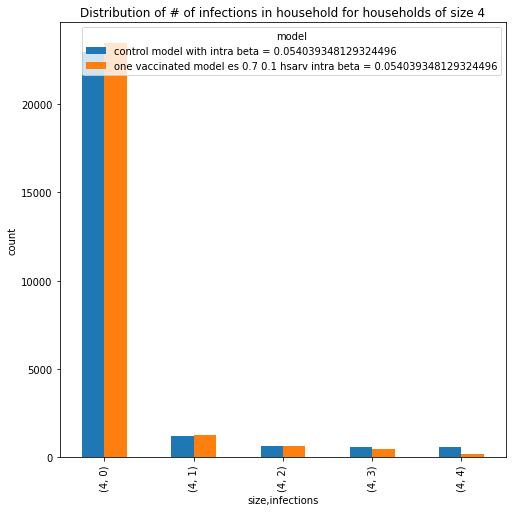

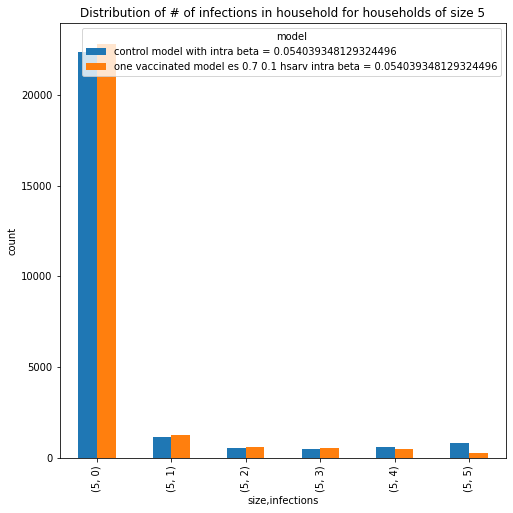

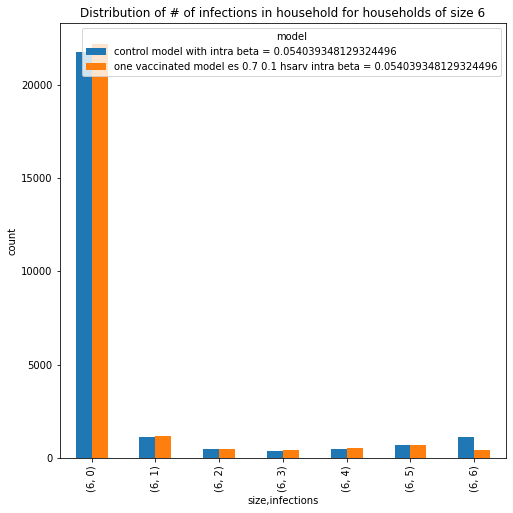

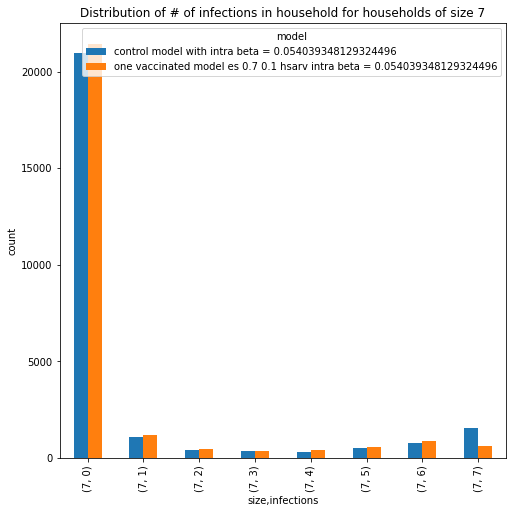

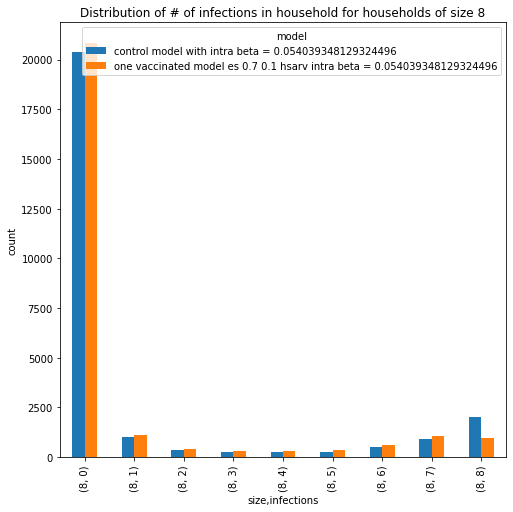

In [69]:
# Running the study some number of times
trials = 200
vax_df, control_df = one_vax_study.run_trials(trials)
make_bar_chart(pd.concat([vax_df, control_df]))

#### Helpful printouts

In [70]:
# Here I list the columns of the dataframes so you can know what kind of information is available in the tables
print("Vaccination df columns", vax_df.columns)
print("Control df columns", control_df.columns)

Vaccination df columns Index(['size', 'model', 'infections', 'num vaccinated', 'vaccinated infected',
       'unvaccinated infected', 'num unvaccinated', 'trialnum'],
      dtype='object')
Control df columns Index(['size', 'model', 'infections', 'num vaccinated', 'vaccinated infected',
       'unvaccinated infected', 'num unvaccinated', 'trialnum'],
      dtype='object')


In [71]:
# mean (over trials) number of placebo recepients who get infected
mean = control_df[control_df["vaccinated infected"] > 0].groupby("trialnum")["vaccinated infected"].count().mean()
total = control_df.groupby("trialnum")["num vaccinated"].count().mean()
print("Percent of placebo reccepients who were infected")
print(100 * mean / total)

# mean (over trials) number of vaccinated recepients who get infected
mean = vax_df[vax_df["vaccinated infected"] > 0].groupby("trialnum")["vaccinated infected"].count().mean() 
total = vax_df.groupby("trialnum")["num vaccinated"].count().mean()
print("Percent of vacccine reccepients who were infected")
100 * mean / total

Percent of placebo reccepients who were infected
10.177692307692308
Percent of vacccine reccepients who were infected


4.43

In [72]:
print("Mean percent of individuals infected in vaccinated households by household size")
infections = vax_df.groupby("size")["infections"].mean()
size = vax_df.groupby("size")["size"].mean()
print(infections / size * 100)

print("Mean percent of individuals infected in unvaccinated households by household size")
infections = control_df.groupby("size")["infections"].mean()
size = control_df.groupby("size")["size"].mean()
print(infections / size * 100)

Mean percent of individuals infected in vaccinated households by household size
size
4     4.421154
5     5.735385
6     7.592949
7     9.604396
8    12.026442
dtype: float64
Mean percent of individuals infected in unvaccinated households by household size
size
4     6.319231
5     7.870769
6     9.792949
7    12.343956
8    14.674038
dtype: float64


In [73]:
print("Percent of vaccinated households of size 4 experienced at least one importation?")
size_four = vax_df[vax_df["size"] == 4]
had_import = size_four[size_four["infections"] > 0].count()

print((had_import / size_four.count())["infections"] * 100)

print("Percent of control households of size 4 experienced at least one importation?")
size_four = control_df[control_df["size"] == 4]
had_import = size_four[size_four["infections"] > 0].count()

print((had_import / size_four.count())["infections"] * 100)

Percent of vaccinated households of size 4 experienced at least one importation?
9.73846153846154
Percent of control households of size 4 experienced at least one importation?
11.61923076923077


#### VE calculation

In [74]:
print("VEtotal")

vetotal_df = one_vax_study.vetotal()
vetotal_df

VEtotal
Calculating VEtotal ...
 Vaccine study named one vaccinated with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


,VE,fisher p value
trialnum,,
0,0.218750,0.000286
1,0.241935,0.000072
2,0.169271,0.011345
3,0.255125,0.000023
4,0.020513,0.790709
...,...,...
195,0.183295,0.003273
196,0.159737,0.008545
197,0.251351,0.000155


In [75]:
print("Power calculation from VEtotal")
power(vetotal_df, 0.3, 0.05)

Power calculation from VEtotal
Calculating power


0.215

In [76]:
print("VEs")
ves_df = one_vax_study.ves()
ves_df

VEs
Calculating VEs ...
 Vaccine study named one vaccinated with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


,VE,fisher p value
trialnum,,
0,0.590909,3.437182e-05
1,0.605634,8.445079e-06
2,0.482759,2.691873e-03
3,0.483871,1.767686e-03
4,0.516129,7.227209e-04
...,...,...
195,0.500000,4.879798e-04
196,0.522388,3.354476e-04
197,0.688525,1.331471e-06


VE                0.559338
fisher p value    0.004258
dtype: float64

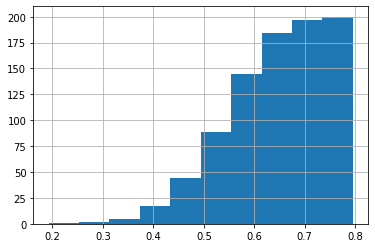

In [77]:
ves_df["VE"].hist(cumulative=True)
ves_df.mean()

In [78]:
print("Power calculation from VEs")
power(ves_df, 0.3, 0.05) # df, threshold/lower_bound

Power calculation from VEs
Calculating power


0.98

In [79]:
print("VEcontact")
vecontact_df = one_vax_study.vecontact()
vecontact_df

VEcontact
Calculating VEcontact ...
 Vaccine study named one vaccinated with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


,VE,fisher p value
trialnum,,
0,0.154450,0.020645
1,0.170799,0.012432
2,0.113497,0.127047
3,0.217507,0.000956
4,-0.073171,0.351284
...,...,...
195,0.121884,0.080938
196,0.097436,0.148931
197,0.165049,0.027886


In [80]:
print("Power calculation from VEcontact")
# Old way
# vecontact_df[vecontact_df > 0].count() / vecontact_df.count()

# New way
power(vecontact_df, 0.3, 0.05)

Power calculation from VEcontact
Calculating power


0.09

#### Looping over n per arm

In [81]:
# Model parameters
sizes = [4,5,6,7,8] # the nhouseholds are divided evenly among the sizes

hsar = 0.3 # the desired household sar when averaged over the sizes of the households

es = 0.7 # Would we prefer another name for this?
#et = 0.3
hsarv = 0.1

## 

duration = 90 # days
importation_rate = 0.01 / duration # 3 percent cumulative risk over study period => to units of / day

In [82]:
n_axis = np.linspace(400, 2000, 5)

vec_pow = []
vet_pow = []
ves_pow = []
for n in n_axis:
    study = VaccineStudy("one vaccinated", n, sizes, hsar, es, (hsarv, 'hsarv'), duration, importation_rate, vaccinate_one)
    trials = 50
    vax_df, control_df = study.run_trials(trials)
    threshold = 0.3
    fisher_p  = 0.05

    vecontact_power = power(study.vecontact(), threshold, fisher_p)
    vetotal_power   = power(study.vetotal(), threshold, fisher_p)
    ves_power       = power(study.ves(), threshold, fisher_p)

    vec_pow.append(vecontact_power)
    vet_pow.append(vetotal_power)
    ves_pow.append(ves_power)

vec_pow = pd.Series(vec_pow)
vec_pow.name="VEcontact"
vet_pow = pd.Series(vet_pow)
vet_pow.name="VEtotal"
ves_pow = pd.Series(ves_pow)
ves_pow.name="VEs"


pow_df = pd.concat([vec_pow, vet_pow, ves_pow], axis=1)
pow_df.index = n_axis

TypeError: ignored

In [ ]:
#pow_df.index = n_axis
pow_df.plot()
#pow_df

### Vaccinating a fraction of each household

In [19]:
print(VaccineStudy.__init__.__doc__)


        Creates a VaccineStudy, which represents a two-armed study with a group of households receiving the vaccine and a group receiving the placebo.

        Parameters
        ----------
        name : str
            a name for the study
        n_per_arm : int
            the total number of households per arm of the study
        sizes : list of ints
            the household sizes among which to divide evenly the total number of households in the study
        hsar : float
            the desired average (over the household sizes specified) household secondary attack rate
        es : float
            the true parameter reduction in a vaccinated individual's susceptibility
        hsarv : float
            the hsar calculated relative to vaccinated individuals
        duration : int
            the duration of the experiment in days
        importation_rate : float
            the baseline (no vax) probability per individual per day of being infected from outside the household

In [20]:
# Model parameters

n_per_arm = 650
sizes = [4,5,6,7,8] # the nhouseholds are divided evenly among the sizes

hsar = 0.3 # the desired household sar when averaged over the sizes of the households
hsarv = 0.1

es = 0.7 # Would we prefer another name for this?

vaccinate_half = functools.partial(vaccinate_fraction,fraction_vaccinated=0.5)

duration = 90 # days
importation_probability_over_study = 0.03
importation_rate = 1-(1-importation_probability_over_study)**(1/duration) # converting risk over study period to daily risk

In [21]:
# quick check that we did the risk correctly
print("Got probability over period =",(1-importation_rate)**90, "Expected =", 1-importation_probability_over_study)

Got probability over period = 0.9700000000000039 Expected = 0.97


In [22]:
half_vax_study = VaccineStudy("half vaccinated", n_per_arm, sizes, hsar, es, (hsarv, 'hsarv'), duration, importation_rate, vaccinate_half)

In [23]:
print("Now we've created a VaccineStudy object. Let's learn more about it.")
print(VaccineStudy.__doc__)

Now we've created a VaccineStudy object. Let's learn more about it.

    A class that hosts and runs a single vaccine study experiment.

    ...

    Attributes
    ----------
    All the attributes passed at object creation. Run `print(VaccineStudy.__init__.__doc__)` for more information. Additionally:

    household_beta : float
        the real probability per contact per day of transmission between individuals in household
    household_sizes : dict
        a dictionary containing the sizes of households in each arm of the study, and the number of households of that size
    vax_sus : float
        the real parameter that defines the susceptibility of vaccinated individuals (0.0 = 0% chance to be infected, 0.1=10% chance relative to unvaccinated)
    vax_inf : float
        the real parameter that defines the infectivity of vaccinated individuals (0.0 = 0% chance to cause infection, 0.1=10% chance relative to unvaccinated)
    vax_m : Model
        a Model object that packages the 

Running study ...
 Vaccine study named half vaccinateed with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496
Warning, attempted to vaccinate fraction=0.5 of household with size=5. Vaccinated 2.0
Warning, attempted to vaccinate fraction=0.5 of household with size=7. Vaccinated 4.0
Warning, attempted to vaccinate fraction=0.5 of household with size=5. Vaccinated 2.0
Warning, attempted to vaccinate fraction=0.5 of household with size=7. Vaccinated 4.0


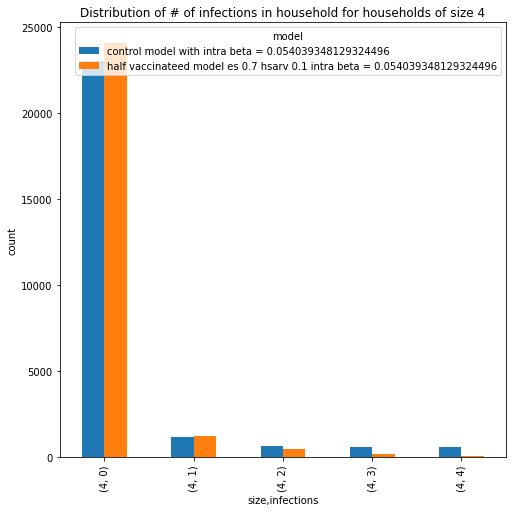

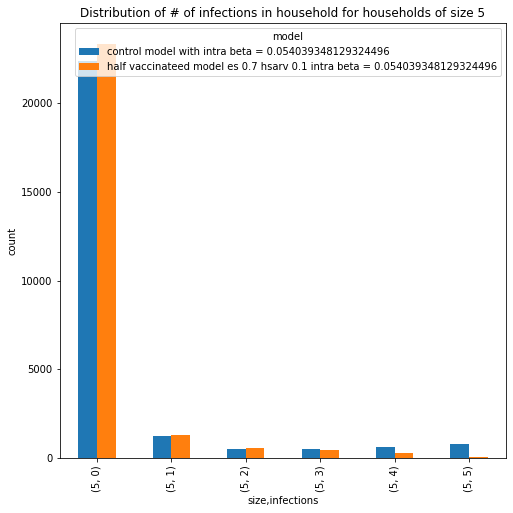

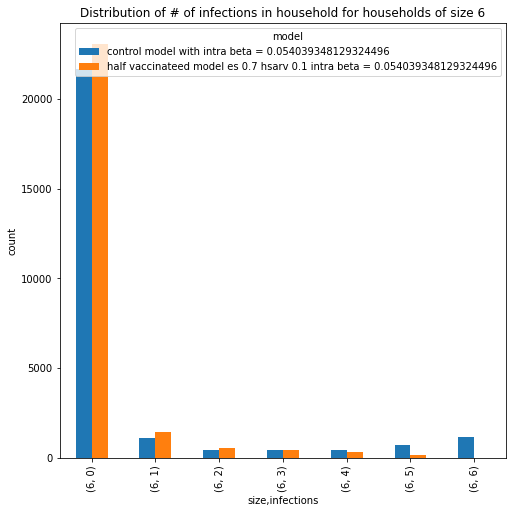

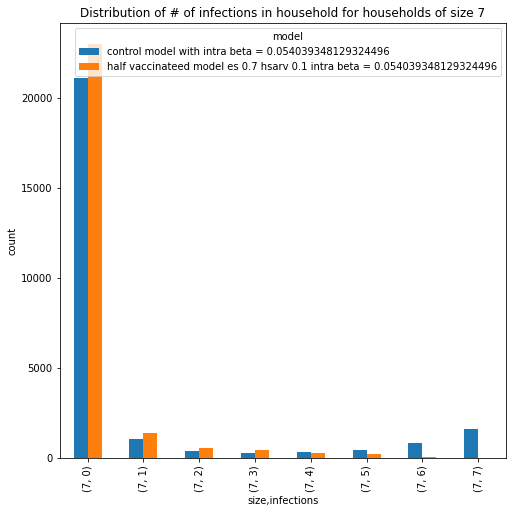

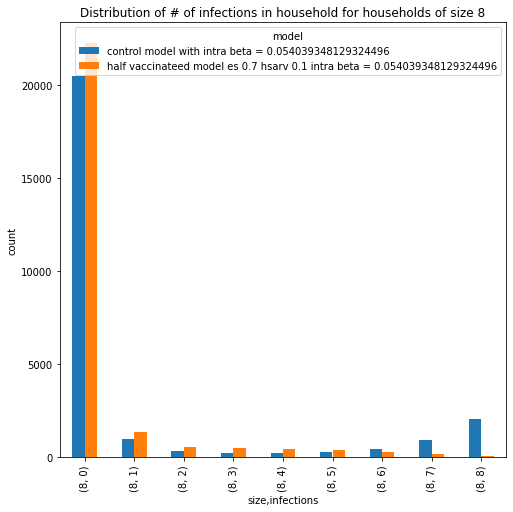

In [24]:
# Running the study some number of times
trials = 200
vax_df, control_df = half_vax_study.run_trials(trials)
make_bar_chart(pd.concat([vax_df, control_df]))

#### Helpful printouts

In [25]:
# Here I list the columns of the dataframes so you can know what kind of information is available in the tables
print("Vaccination df columns", vax_df.columns)
print("Control df columns", control_df.columns)

Vaccination df columns Index(['size', 'model', 'infections', 'num vaccinated', 'vaccinated infected',
       'unvaccinated infected', 'num unvaccinated', 'trialnum'],
      dtype='object')
Control df columns Index(['size', 'model', 'infections', 'num vaccinated', 'vaccinated infected',
       'unvaccinated infected', 'num unvaccinated', 'trialnum'],
      dtype='object')


In [26]:
# mean (over trials) number of placebo recepients who get infected
mean = control_df[control_df["vaccinated infected"] > 0].groupby("trialnum")["vaccinated infected"].count().mean()
total = control_df.groupby("trialnum")["num vaccinated"].count().mean()
print("Percent of placebo reccepients who were infected")
print(100 * mean / total)

# mean (over trials) number of vaccinated recepients who get infected
mean = vax_df[vax_df["vaccinated infected"] > 0].groupby("trialnum")["vaccinated infected"].count().mean() 
total = vax_df.groupby("trialnum")["num vaccinated"].count().mean()
print("Percent of vacccine reccepients who were infected")
100 * mean / total

Percent of placebo reccepients who were infected
13.825384615384616
Percent of vacccine reccepients who were infected


5.792307692307692

In [27]:
print("Mean percent of individuals infected in vaccinated households by household size")
infections = vax_df.groupby("size")["infections"].mean()
size = vax_df.groupby("size")["size"].mean()
print(infections / size * 100)

print("Mean percent of individuals infected in unvaccinated households by household size")
infections = control_df.groupby("size")["infections"].mean()
size = control_df.groupby("size")["size"].mean()
print(infections / size * 100)

Mean percent of individuals infected in vaccinated households by household size
size
4    2.803846
5    4.036154
6    3.917308
7    3.726374
8    5.290385
dtype: float64
Mean percent of individuals infected in unvaccinated households by household size
size
4     6.328846
5     7.783846
6    10.098718
7    12.290110
8    14.565385
dtype: float64


In [28]:
print("Percent of vaccinated households of size 4 experienced at least one importation")
size_four = vax_df[vax_df["size"] == 4]
had_import = size_four[size_four["infections"] > 0].count()

print((had_import / size_four.count())["infections"] * 100)

print("Percent of control households of size 4 experienced at least one importation")
size_four = control_df[control_df["size"] == 4]
had_import = size_four[size_four["infections"] > 0].count()

print((had_import / size_four.count())["infections"] * 100)

Percent of vaccinated households of size 4 experienced at least one importation?
7.484615384615384
Percent of control households of size 4 experienced at least one importation?
11.515384615384615


#### VE calculation

In [29]:
print("VEtotal")

vetotal_df = half_vax_study.vetotal()
vetotal_df

VEtotal
Calculating VEtotal ...
 Vaccine study named half vaccinateed with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


,VE,fisher p value
trialnum,,
0,0.617849,5.088702e-31
1,0.674058,1.216864e-39
2,0.571802,1.227888e-22
3,0.536817,1.336862e-21
4,0.640827,6.684703e-30
...,...,...
195,0.680272,1.243661e-39
196,0.622426,1.429053e-31
197,0.561881,5.882245e-23


In [30]:
print("Power calculation from VEtotal")
power(vetotal_df, 0.3, 0.05)

Power calculation from VEtotal
Calculating power


1.0

In [31]:
print("VEs")
ves_df = half_vax_study.ves()
ves_df

VEs
Calculating VEs ...
 Vaccine study named half vaccinateed with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


,VE,fisher p value
trialnum,,
0,0.747706,1.011442e-25
1,0.820175,1.055449e-34
2,0.760204,3.940705e-24
3,0.735849,5.491239e-24
4,0.783251,4.328149e-27
...,...,...
195,0.793722,6.433988e-31
196,0.744395,5.112308e-26
197,0.712919,8.181519e-22


VE                7.615635e-01
fisher p value    9.466719e-14
dtype: float64

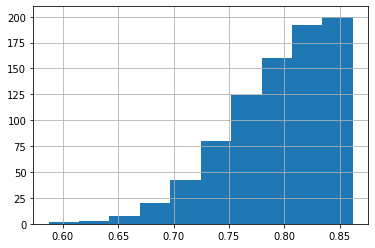

In [32]:
ves_df["VE"].hist(cumulative=True)
ves_df.mean()

In [33]:
print("Power calculation from VEs")
power(ves_df, 0.3, 0.05) # df, threshold/lower_bound

Power calculation from VEs
Calculating power


1.0

In [34]:
print("VEcontact")
vecontact_df = half_vax_study.vecontact()
vecontact_df

VEcontact
Calculating VEcontact ...
 Vaccine study named half vaccinateed with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, hsarv        = 0.7, 0.1
	vax_sus, vax_inf   = 0.30000000000000004, 0.2833751573750291
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496


,VE,fisher p value
trialnum,,
0,0.488584,8.320839e-10
1,0.524664,1.494636e-11
2,0.374332,3.519341e-05
3,0.334928,1.016132e-04
4,0.483696,3.590971e-08
...,...,...
195,0.564220,3.400477e-13
196,0.495327,7.302421e-10
197,0.400000,4.982596e-06


In [35]:
print("Power calculation from VEcontact")
# New way
power(vecontact_df, 0.3, 0.05)

Power calculation from VEcontact
Calculating power


0.95

## Backing out true parameters

In [98]:
# Model parameters
n_baseline = 800
sizes = [4,5,6,7,8] # the nhouseholds are divided evenly among the sizes

hsar = 0.3 # the desired household sar when averaged over the sizes of the households
#hsarv = 0.1
et=0.3

es = 0.7 # Would we prefer another name for this?

vaccination_method = functools.partial(vaccinate_fraction,fraction_vaccinated=0.5)

duration = 90 # days
importation_probability_over_study = 0.03
importation_rate = 1-(1-importation_probability_over_study)**(1/duration) # converting risk over study period to daily risk

baseline_study = VaccineStudy("half vaccinated", n_per_arm, sizes, hsar, es, (et, 'et'), duration, importation_rate, vaccinate_half)
baseline_vax_df, _ = baseline_study.run_trials(10, arms='vax')

Running study ...
 Vaccine study named half vaccinated with:
	n_per_arm        = 650
	household sizes  = {4: 130, 5: 130, 6: 130, 7: 130, 8: 130}
	es, et        = 0.7, 0.3
	vax_sus, vax_inf   = 0.30000000000000004, 0.7
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496
Warning, attempted to vaccinate fraction=0.5 of household with size=5. Vaccinated 2.0
Warning, attempted to vaccinate fraction=0.5 of household with size=7. Vaccinated 4.0


In [ ]:
# Likelihood surface
sus_axis = np.linspace(0.0, 1.0, 21)
inf_axis = np.linspace(0.0, 1.0, 21)

trials = 1 # only 1 trial here because we are creating one infinitely large simulated population
inf_dfs = []
for inf in inf_axis:
    sus_dfs = []
    for sus in sus_axis:
        v_name = "vax_sus={0}, vax_inf={1}".format(sus,inf)
        n_hh = 10000
        study = VaccineStudy(v_name, n_hh, sizes, hsar, 1-sus, (1-inf, 'et'), duration, importation_rate, vaccination_method)
        simulated_df, _ = study.run_trials(1, arms='vax')
        baseline_grouped = baseline_vax_df.groupby("trialnum")

        logls = baseline_grouped.apply(lambda g: calculate_likelihoods(simulated_df, g))
        logls.name = "%.2f" % sus
        sus_dfs.append(logls)
    
    sus_df = pd.concat(sus_dfs, axis=1)
    sus_df["inf"] = inf
    inf_dfs.append(sus_df)

inf_df = pd.concat(inf_dfs)
inf_df

Running study ...
 Vaccine study named vax_sus=0.0, vax_inf=0.0 with:
	n_per_arm        = 10000
	household sizes  = {4: 2000, 5: 2000, 6: 2000, 7: 2000, 8: 2000}
	es, et        = 1.0, 1.0
	vax_sus, vax_inf   = 0.0, 0.0
	duration         = 90
	importation rate = 0.00033837837583827746
	household beta   = 0.054039348129324496
Warning, attempted to vaccinate fraction=0.5 of household with size=5. Vaccinated 2.0
Warning, attempted to vaccinate fraction=0.5 of household with size=7. Vaccinated 4.0


,0.00,0.20,0.40,0.60,0.80,1.00,inf
trialnum,,,,,,,
0,-inf,-inf,-inf,-65.700542,-64.132136,-67.150545,0.0
1,-inf,-inf,-inf,-47.532592,-56.304581,-52.961789,0.0
2,-inf,-inf,-inf,-53.386212,-61.493648,-59.117413,0.0
3,-inf,-inf,-inf,-64.343053,-65.721667,-65.746369,0.0
4,-inf,-inf,-50.467953,-47.778793,-49.081397,-53.571964,0.0
5,-inf,-inf,-54.658497,-53.595812,-56.574289,-57.773340,0.0
6,-inf,-inf,-54.920922,-60.649362,-62.688748,-68.250038,0.0
7,-inf,-inf,-inf,-55.195721,-59.964364,-59.652351,0.0
8,-inf,-inf,-inf,-53.738523,-57.204270,-62.551651,0.0


In [96]:
df = inf_df.groupby('inf').mean()
df = df.replace({-np.inf: np.nan}) # NOTE THIS IS NOT SAFE ALL THE TIME BECAUSE IT SKEWS MEAN TO READ MORE LIKELY DUE TO NANS

df

,0.00,0.20,0.40,0.60,0.80,1.00
inf,,,,,,
0.0,NaN,NaN,NaN,-55.323055,-59.272169,-60.719564
0.2,NaN,NaN,NaN,-53.448775,-57.557908,-61.479490
0.4,NaN,NaN,-51.128664,-53.045364,-60.475953,-64.754328
0.6,NaN,NaN,-50.285137,-54.401901,-62.683243,-68.349571
0.8,NaN,NaN,-52.241092,-56.416980,-65.342207,-76.290526
1.0,NaN,NaN,-51.126507,-61.276540,-71.779190,-81.299588


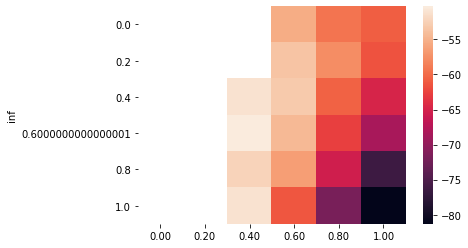

In [97]:
sns.heatmap(df, mask=df.isna())

### Experiments with just modifying susceptibilities

In [ ]:
fractions_vaccinated = np.array([1/6, 2/6, 3/6, 4/6, 5/6, 6/6])
susceptibilities = [0., 0.1, 0.2, 0.3]

household_beta = 0.005
duration = 45 # in days
importation_rate = 0.00014
household_sizes = {18:50}
trials = 150

dfs = []
for s in susceptibilities:
    effects = []
    for f in fractions_vaccinated:
        sus_dist = functools.partial(partial_immunity, fraction_vaccinated=f, susceptibility=s)

        control_model = Model("control", importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
        vaccinated_model = Model("vaccinated", sus_dist=sus_dist, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)

        cdf = run_trials(control_model, trials, household_beta, household_sizes)
        vdf = run_trials(vaccinated_model, trials, household_beta, household_sizes)

        effect = vdf.groupby(["trialnum"]).mean() / cdf.groupby(["trialnum"]).mean()
        effect["fraction vaccinated"] = f

        effects.append(effect)

    effects = pd.concat(effects).drop(columns="size")
    effects["vaccinated susceptibility"] = s

    dfs.append(effects)

effects_df = pd.concat(dfs)

effects_df

In [ ]:
grouped = effects_df.groupby(["vaccinated susceptibility", "fraction vaccinated"])

mean_df = grouped.mean().unstack(level=0)
mean_df.columns = mean_df.columns.get_level_values(1)

std_df = grouped.std().unstack(level=0)
std_df.columns = std_df.columns.get_level_values(1)

mean_df.plot(title="Mean infections vaccinated / mean infections control at different fractions vaccinated",yerr=std_df, ylabel="mean infections vaccinated / mean infections control")

In [ ]:
# Likelihood surfaces in one parameter model (just varying sus)

# setup
household_beta = 0.005
duration = 45 # in days
importation_rate = 0.00014
size = 50
household_sizes = {18:size}

# empirical figures
many_sus = [0.05, 0.15, 0.25, 0.35, 0.45]
fraction_vaccinated = 0.5


trials = 20

e_dfs = []
for vax_sus in many_sus:

    r0 = household_beta * size
    mean_sus = (1-fraction_vaccinated)*1 + fraction_vaccinated * vax_sus

    print("Implied R0: {0}".format(r0))
    print("Implied mean population susceptibility {0}".format(mean_sus))

    e_sus = functools.partial(partial_immunity, fraction_vaccinated=fraction_vaccinated, susceptibility=vax_sus)
    e_model = Model("empirical vaccinated", sus_dist=e_sus, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
    _df = run_trials(e_model, trials, household_beta, household_sizes)
    _df["vax_sus"] = vax_sus
    e_dfs.append(_df)

e_df = pd.concat(e_dfs)

e_df

In [ ]:
e_df

In [ ]:
# Likelihood surface

sus_axis = np.linspace(0.0, 1.0, 21)
trials = 1
household_sizes = {18:4000}

dfs = []
means = []

for vax_sus in many_sus: # I don't need to have the for loop here: I'm doing too much work. I just need to compare to the for loop in the innermost position
    logls = []
    for sus in sus_axis:
        sus_dist = functools.partial(partial_immunity, fraction_vaccinated=fraction_vaccinated, susceptibility=sus)
        sus_model = Model("sus={0}".format(sus), sus_dist=sus_dist, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
        simulated_df = run_trials(sus_model, trials, household_beta, household_sizes)
        print("vax_sus {0} guess sus {1}".format(vax_sus, sus))
        e_grouped = e_df.groupby(["trialnum"])
        _logl = e_grouped.apply(lambda g: calculate_likelihoods(simulated_df, g[g["vax_sus"] == vax_sus])) # this gives the loglikehihoods (for each trial) at the given vax_sus and guessed sus
        _logl.name = "%.2f" % sus

        logls.append(_logl)

    logl = pd.concat(logls, axis=1)
    logl["vax_sus"] = vax_sus
    dfs.append(logl)
    #print(logl)
    
df = pd.concat(dfs)

#print("Sus, mean infections")
#print(zip(sus_axis, means))
#for logls in dfs:
#    logls.plot()

In [ ]:
# Some summary statistics about number of infections
df.describe()

In [ ]:
df = df.replace({-np.inf: None}) # NOTE THIS IS NOT SAFE ALL THE TIME BECAUSE IT SKEWS MEAN TO READ MORE LIKELY
df

In [ ]:
df.groupby("vax_sus").std()
df.groupby("vax_sus").mean()

In [ ]:
yerr = df.groupby("vax_sus").std()
df.groupby("vax_sus").mean().T.plot(title="Log likelihood of observing the 'empirical' (r0={0} sus of vaccinated={1}) data versus susceptibility of vaccinated".format(r0, vax_sus), yerr=yerr, ylabel="log likelihood", xlabel="susceptibility guess")

### Likelihood surfaces in a 2 parameter model (sus and inf modified by vaccine)

In [ ]:
# Likelihood surfaces in the two parameter model (sus and inf affected)

# setup
household_beta = 0.005
duration = 45 # in days
importation_rate = 0.00014
size = 100
household_sizes = {18:size}

# empirical figures
vax_sus = 0.3
vax_inf = 0.5
fraction_vaccinated = 0.5

r0 = household_beta * size
mean_sus = (1-fraction_vaccinated)*1 + fraction_vaccinated * vax_sus
mean_inf = (1-fraction_vaccinated)*1 + fraction_vaccinated * vax_inf

print("Implied R0: {0}".format(r0))
print("Implied mean population susceptibility {0}".format(mean_sus))
print("Implied mean population infectivity {0}".format(mean_inf))


e_sus = functools.partial(partial_immunity, fraction_vaccinated=fraction_vaccinated, susceptibility=vax_sus)
e_inf = functools.partial(modified_infectivity, fraction_vaccinated=fraction_vaccinated, infectivity=vax_inf)
e_model = Model("empirical vaccinated", sus_dist=e_sus, inf_dist=e_inf, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
trials = 20
e_df = run_trials(e_model, trials, household_beta, household_sizes)

e_df

In [ ]:
# Likelihood surface
sus_axis = np.linspace(0.0, 1.0, 21)
inf_axis = np.linspace(0.0, 1.0, 21)
trials = 1 # only 1 trial here because we are creating one infinitely large simulated population
household_sizes = {18:4000}
fraction_vaccinated = 0.5

inf_dfs = []
for inf in inf_axis:
    sus_dfs = []
    inf_dist = functools.partial(modified_infectivity, fraction_vaccinated=fraction_vaccinated, infectivity=inf)
    for sus in sus_axis:
        sus_dist = functools.partial(partial_immunity, fraction_vaccinated=fraction_vaccinated, susceptibility=sus)
        composite_model = Model("sus={0}".format(sus), sus_dist=sus_dist, inf_dist=inf_dist, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
        simulated_df = run_trials(composite_model, trials, household_beta, household_sizes)

        #means.append(simulated_df["infections"].mean())
        e_grouped = e_df.groupby(["trialnum"])

        logls = e_grouped.apply(lambda g: calculate_likelihoods(simulated_df, g))
        logls.name = "%.2f" % sus
        sus_dfs.append(logls)
        #likelihoods(df, e_df.groupby(["trialnum"]))

    sus_df = pd.concat(sus_dfs, axis=1)
    sus_df["inf"] = inf
    inf_dfs.append(sus_df)

inf_df = pd.concat(inf_dfs)
inf_df
#print("Sus, mean infections")
#print(zip(sus_axis, means)))

df = inf_df.groupby('inf').mean()
df = df.replace({-np.inf: np.nan}) # NOTE THIS IS NOT SAFE ALL THE TIME BECAUSE IT SKEWS MEAN TO READ MORE LIKELY

df

In [ ]:
df = inf_df.groupby('inf').mean()
df = df.replace({-np.inf: np.nan}) # NOTE THIS IS NOT SAFE ALL THE TIME BECAUSE IT SKEWS MEAN TO READ MORE LIKELY

df

In [ ]:
sns.heatmap(df, mask=df.isna())

#### With variable rates of vaccination

In [ ]:
# Likelihood surfaces in the two parameter model (sus and inf affected)

# vaccine parameters
vax_sus = 0.3
vax_inf = 0.5

# model parameters
household_beta = 0.005
duration = 45 # in days
importation_rate = 0.00014
size = 100
household_sizes = {18:size}


# model objects
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]

e_models = []
for f in fractions:
    # model of vaccinated population
    vax_sus_dist = functools.partial(partial_immunity, fraction_vaccinated=f, susceptibility=vax_sus)
    vax_inf_dist = functools.partial(modified_infectivity, fraction_vaccinated=f, infectivity=vax_inf)

    m = Model(f, sus_dist=vax_sus_dist, inf_dist=vax_inf_dist, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
    e_models.append(m)


    r0 = household_beta * size
    mean_sus = (1-fraction_vaccinated)*1 + fraction_vaccinated * vax_sus
    mean_inf = (1-fraction_vaccinated)*1 + fraction_vaccinated * vax_inf

    print("Implied R0: {0}".format(r0))
    print("Implied mean population susceptibility {0}".format(mean_sus))
    print("Implied mean population infectivity {0}".format(mean_inf))

trials = 20
e_dfs = []
for m in e_models:
    _df = run_trials(m, trials, household_beta, household_sizes)
    _df["fraction vaccinated"] = m.name

    e_dfs.append(_df)

e_df = pd.concat(e_dfs)

e_df

In [ ]:
# Likelihood surface with mutiple fractions
sus_axis = np.linspace(0.0, 1.0, 11)
inf_axis = np.linspace(0.0, 1.0, 11)
trials = 1 # only 1 trial here because we are trying to create one infinitely large simulated population
household_sizes = {18:4500}

fractions = [0.2, 0.4, 0.6, 0.8, 1.0]

inf_dfs = []
for inf in inf_axis:
    sus_dfs = []
    for sus in sus_axis:
        logls = []
        for f in fractions:
            inf_dist = functools.partial(modified_infectivity, fraction_vaccinated=f, infectivity=inf)
            sus_dist = functools.partial(partial_immunity, fraction_vaccinated=f, susceptibility=sus)

            composite_model = Model("sus={0}".format(sus), sus_dist=sus_dist, inf_dist=inf_dist, importation_rate=importation_rate, infection_seeding=seed_zero, duration=duration)
            simulated_df = run_trials(composite_model, trials, household_beta, household_sizes)

            e_grouped = e_df.groupby(["trialnum"])

            _logl = e_grouped.apply(lambda g: calculate_likelihoods(simulated_df, g[g["fraction vaccinated"] == f]))
            _logl.name = "%.2f" % sus
            print(_logl)
            logls.append(_logl)
        
        logl = sum(logls) # the sum of the (log) likelihoods at a given fraction gives an overall likelihood for the mixed population
        print("SUMMED:", logl)
        sus_dfs.append(logl)
    sus_df = pd.concat(sus_dfs, axis=1)
    sus_df["inf"] = inf
    inf_dfs.append(sus_df)

df = pd.concat(inf_dfs)


    #inf_df
#print("Sus, mean infections")
#print(zip(sus_axis, means)))

In [ ]:
df = pd.concat(inf_dfs)
df

In [ ]:
df = df.groupby('inf').median()
df = df.replace({-np.inf: np.nan}) # NOTE THIS IS NOT SAFE ALL THE TIME BECAUSE IT SKEWS MEAN TO READ MORE LIKELY

df

In [ ]:
sns.heatmap(df, mask=df.isna())
plt.xlabel("sus guess")
plt.ylabel("inf guess")
plt.title("Median log likelihood of observing empirical data at R0={0}, true sus={1}, true inf={2}, over {3} trials".format(r0, vax_sus, vax_inf, trials))